In [1]:
!nvidia-smi

Sun Mar 21 12:15:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

#Important Paths

In [5]:
root = '/content'
code_dir = root + '/reverse-voice-filter'
norm_path = code_dir + '/utils/normalize-resample.sh'
dataset_root = root + '/LibriSpeech'
config_path = '/content/reverse-voice-filter/config'

# Git Repo

In [ ]:
!git clone https://github.com/palette-knife25/reverse-voice-filter.git
os.chdir(code_dir)
!pip3 install -r /content/reverse-voice-filter/requirements.txt
!pip3 install ffmpeg-normalize

# Dataset

## Downloading

### Dev data

In [ ]:
os.chdir(root)
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz
!tar -zxf dev-clean.tar.gz && rm dev-clean.tar.gz

### All data

In [ ]:
#os.chdir(root)
#!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
#!tar -xzf train-clean-100.tar.gz && rm train-clean-100.tar.gz

#!wget https://www.openslr.org/resources/12/train-clean-360.tar.gz
#!tar -xzf train-clean-360.tar.gz && rm train-clean-360.tar.gz

## Normalization

In [ ]:
!cp $norm_path $dataset_root
os.chdir(dataset_root)
!chmod a+x normalize-resample.sh
!./normalize-resample.sh 

##Configuration

In [10]:
os.chdir(config_path)
!cp default.yaml config.yaml
os.chdir(code_dir)

Specify this in config.yaml:

train_dir: '/content/reverse-voice-filter/train'

test_dir: '/content/reverse-voice-filter/test'

checkpoint_interval: desired checkpoint interval (we suggest 100)

## Generation

Remove "--only_dev True" if you are running on the whole data.

Add "--reverse_data True" if you want to generate reverse dataset (where noise is target)

In [17]:
!python generator.py -c /content/reverse-voice-filter/config/config.yaml -d /content/LibriSpeech -o /content/reverse-voice-filter --only_dev True

100% 40/40 [00:00<00:00, 64.82it/s]
100% 40/40 [00:00<00:00, 48.00it/s]


# Training

## Get pretrained model for speaker recognition system

In [ ]:
# Download from https://drive.google.com/file/d/1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL/view
# and put into the root (/content) folder

## Training loop (will run indefinetely)

In [18]:
os.chdir("/content/reverse-voice-filter/")

The following cell will run indefinetely. You need to stop the execution when the desired checkpoint is saved.

In [ ]:
!python trainer.py -c /content/reverse-voice-filter/config/config.yaml -e /content/embedder.pt -m "dev_set_model"

# Evaluation

## Inference

In [ ]:
os.chdir("/content/reverse-voice-filter/")

In [41]:
# run this to apply mask in original way: result audio = mixed spectrogram * mask
!python inference.py -c /content/reverse-voice-filter/config/config.yaml -e /content/embedder.pt --checkpoint_path /content/reverse-voice-filter/chkpt/dev_set_model/chkpt_10.pt -m /content/reverse-voice-filter/train/000000-mixed.wav -r /content/reverse-voice-filter/train/000000-target.wav -o /content/res --mask org

In [33]:
# run this to apply mask in reversed way: result audio = 0.7 * mixed spectrogram / mask
#!python inference.py -c /content/reverse-voice-filter/config/config.yaml -e /content/embedder.pt --checkpoint_path /content/reverse-voice-filter/chkpt/dev_set_model/chkpt_10.pt -m /content/reverse-voice-filter/train/000000-mixed.wav -r /content/reverse-voice-filter/train/000000-target.wav -o /content/res --mask inv_div --factor 0.7

In [37]:
# run this to apply mask in reversed way: result audio = mixed spectrogram * (1 - mask) / 0.7
#!python inference.py -c /content/reverse-voice-filter/config/config.yaml -e /content/embedder.pt --checkpoint_path /content/reverse-voice-filter/chkpt/dev_set_model/chkpt_10.pt -m /content/reverse-voice-filter/train/000000-mixed.wav -r /content/reverse-voice-filter/train/000000-target.wav -o /content/res --mask inv_sub --factor 0.7

In [30]:
import IPython.display as ipd
ipd.Audio('/content/reverse-voice-filter/train/000000-mixed.wav')

In [31]:
ipd.Audio('/content/reverse-voice-filter/train/000000-target.wav')

In [65]:
ipd.Audio('/content/res/result.wav')

In [3]:
# You can download your resluts

from google.colab import files
files.download('/content/res/result.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot the results

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

def wav2spec(y):
    D = stft(y)
    S = amp_to_db(np.abs(D)) - 20.0
    S, D = normalize(S), np.angle(D)
    S, D = S.T, D.T # to make [time, freq]
    return S, D

def stft(y):
    return librosa.stft(y=y, n_fft=1200,
                        hop_length=160,
                        win_length=400)
def amp_to_db(x):
    return 20.0 * np.log10(np.maximum(1e-5, x))

def normalize(S):
    return np.clip(S / -(-100.0), -1.0, 0.0) + 1.0

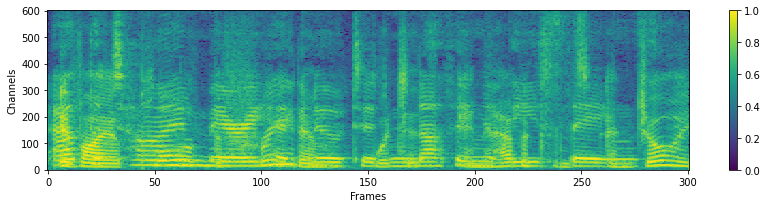

In [2]:
mixed_wav, _ = librosa.load('/content/res/result.wav', sr=16000)
mag, phase = wav2spec(mixed_wav)

fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(mag.T, aspect='auto', origin='lower', interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel('Frames')
plt.ylabel('Channels')
plt.tight_layout()
plt.show()

## Download the checkpoint

In [ ]:
files.download("/content/voicefilter/chkpt/dev_set_model/chkpt_400.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Resume training from checkpoint

In [ ]:
!python trainer.py -c /content/voicefilter/config/config.yaml --checkpoint_path /content/voicefilter/chkpt/dev_set_model/chkpt_400.pt -e /content/voicefilter/embedder.pt -m "dev_set_model"

# Tensorboard visualization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/voicefilter/logs